# Inventory management via Python/Numba

In [1]:
import quantecon as qe
import numpy as np
from collections import namedtuple
from numba import njit, prange, int32
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

## Model and Primitives

In [2]:
def f(y, a, d):
    " Inventory update rule. "
    return np.maximum(y - d, 0) + a 

In [3]:
Params = namedtuple(   # Stores model parameters
         "Params", ("K", "c", "κ", "p"))

In [4]:
def build_R(params, y_vals, d_vals, ϕ_vals):
    K, c, κ, p = params
    n_y = K + 1
    n_d = len(d_vals)
    # Create R[y, a, yp, d] and then sum out last dimension
    y  = np.reshape(y_vals, (n_y, 1, 1, 1))
    a  = np.reshape(y_vals, (1, n_y, 1, 1))
    yp = np.reshape(y_vals, (1, 1, n_y, 1))
    d  = np.reshape(d_vals, (1, 1, 1, n_d))
    ϕ  = np.reshape(ϕ_vals, (1, 1, 1, n_d))
    feasible = a <= K - y
    temp = (f(y, a, d_vals) == yp) * feasible
    R = np.sum(temp * ϕ_vals, axis=3)
    return R

In [5]:
def build_r(params, y_vals, d_vals, ϕ_vals):
    K, c, κ, p = params
    n_y = K + 1
    n_d = len(d_vals)
    y = np.reshape(y_vals, (n_y, 1))
    d = np.reshape(d_vals, (1, n_d))
    ϕ = np.reshape(ϕ_vals, (1, n_d))
    revenue = np.minimum(y, d) * ϕ 
    exp_revenue = np.sum(revenue, axis=1)
    exp_revenue = np.reshape(exp_revenue, (n_y, 1))
    a = np.reshape(y_vals, (1, n_y))
    cost = c * a + κ * (a > 0)
    exp_profit = exp_revenue - cost
    feasible = a <= K - y
    r = np.where(feasible, exp_profit, -np.inf)
    return r

In [6]:
Arrays = namedtuple(  # Stores arrays for model
         "Arrays", ("r", "R", "y_vals", "z_vals", "Q"))

In [7]:
Model = namedtuple(   # Stores all model data
        "Model", ("params", "sizes", "arrays"))

In [8]:
def create_sdd_inventory_model(ρ=0.98,        # Z persistence
                               ν=0.002,       # Z volatility
                               n_z=12,        # size of Z grid
                               b=0.97,        # Z mean
                               K=100,         # max inventory        
                               d_max=100,     # max value of d
                               c=0.2,         # unit cost
                               κ=0.8,         # fixed cost
                               p=0.6):        # demand parameter

    """
    Stores inventory management model primitives and default values.

    The discount factor takes the form β_t = Z_t, where (Z_t) is a 
    Tauchen discretization of the Gaussian AR(1) process 

        Z_t = ρ Z_{t-1} + b + ν W_t.

    """


    n_y = K + 1               # size of state space
    y_vals = np.arange(n_y)   # inventory levels 0,...,K

    # Construct r and R arrays
    def ϕ(d):
        return (1 - p)**d * p                      
    d_vals = np.arange(d_max)
    ϕ_vals = ϕ(d_vals)

    # Build the exogenous discount process 
    mc = qe.tauchen(n_z, ρ, ν)
    z_vals, Q = mc.state_values + b, mc.P

    # Test spectral radius condition
    ρL = np.max(np.abs(np.linalg.eigvals(z_vals * Q)))     
    if ρL >= 1:
        raise NotImplementedError("Error: ρ(L) ≥ 1.")
    else:
        print(f"Building model with ρ(L) = {ρL}")

    # Build namedtuples and return them
    params = Params(K=K, c=c, κ=κ, p=p)
    r = build_r(params, y_vals, d_vals, ϕ_vals)
    R = build_R(params, y_vals, d_vals, ϕ_vals)

    arrays = Arrays(r=r, R=R, y_vals=y_vals, z_vals=z_vals, Q=Q)
    sizes = n_y, n_z
    return Model(params=params, sizes=sizes, arrays=arrays)

## DP algorithms

In [9]:
def value_function_iteration(v_init, 
                             T,
                             get_greedy,
                             tolerance=1e-6,        # Error tolerance
                             max_iter=10_000,       # Max iteration bound
                             print_step=25,         # Print at multiples
                             verbose=False,
                             usejax=False):
    """
        Compute v_star via VFI and then compute greedy.
    """
    array_lib = jnp if usejax else np

    v = v_init
    error = tolerance + 1
    k = 1
    while error > tolerance and k <= max_iter:
        v_new = T(v)
        error = array_lib.max(array_lib.abs(v_new - v))
        if verbose and (k % print_step) == 0:
            print(f"Completed iteration {k} with error {error}.")
        v = v_new
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    elif verbose:
        print(f"VFI terminated successfully in {k} iterations.")
    v_star = v
    σ_star = get_greedy(v_star)
    return v_star, σ_star

In [10]:
def optimistic_policy_iteration(v_init, 
                                T_σ,
                                get_greedy,
                                m=20,
                                tolerance=1e-6, 
                                max_iter=1_000,
                                print_step=10,
                                verbose=False,
                                usejax=False):
    "Optimistic policy iteration routine."
    
    array_lib = jnp if usejax else np
    v = v_init
    error = tolerance + 1
    k = 1
    while error > tolerance and k < max_iter:
        last_v = v
        σ = get_greedy(v)
        for i in range(m):
            v = T_σ(v, σ)
        error = array_lib.max(array_lib.abs(v - last_v))
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    else: 
        print(f"OPI terminated successfully in {k} iterations (m = {m}).")
    return v, get_greedy(v)

In [11]:
def howard_policy_iteration(v_init, 
                            get_value,
                            get_greedy,
                            verbose=False,
                            usejax=False):
    "Howard policy iteration routine."
    array_lib = jnp if usejax else np

    σ = get_greedy(v_init)
    i, error = 0, 1.0
    while error > 0:
        v_σ = get_value(σ)
        σ_new = get_greedy(v_σ)
        error = array_lib.max(array_lib.abs(σ_new - σ))
        σ = σ_new
        i = i + 1
        if verbose:
            print(f"Concluded loop {i} with error {error}.")
    print(f"HPI converged in {i} iteration(s).")
    return v_σ, σ

## Code for simulations and plots

In [12]:
def sim_inventories(model, σ_star, ts_length, Y_init=0, seed=500):
    """
        Simulate inventory dynamics and interest rates given an 
        optimal policy σ_star.
    """
    # Set up
    np.random.seed(seed)
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays

    # Generate Markov chain for discount factor
    z_mc = qe.MarkovChain(Q, z_vals)
    i_z = z_mc.simulate_indices(ts_length, init=1, random_state=seed)

    # Generate corresponding inventory series
    Y = np.zeros(ts_length, dtype=int)
    Y[0] = Y_init
    for t in range(ts_length - 1):
        D = np.random.geometric(p) - 1
        a = σ_star[Y[t], i_z[t]] 
        Y[t+1] = f(Y[t],  a,  D)

    # Return both series
    return Y, z_vals[i_z]

In [13]:
def plot_ts(model,
            σ_star,
            ts_length=400,
            fontsize=12, 
            figname="ts.pdf",
            savefig=False):
    """
        Solve model, plot a time series of inventory and interest rates.

    """

    # Obtain inventory and discount factor series
    Y, Z = sim_inventories(model, σ_star, ts_length)
    r = (1 / Z) - 1 # calculate interest rate from discount factors

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(9, 5.5))
    ax = axes[0]
    ax.plot(Y, label="inventory", alpha=0.7)
    ax.set_xlabel("time", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_ylim(0, np.max(Y)+3)
    ax = axes[1]
    ax.plot(r, label="$r_t$", alpha=0.7)
    ax.set_xlabel("$t$", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=False)
    plt.tight_layout()
    plt.show()
    if savefig:
        fig.savefig(figname)

In [14]:
def plot_timing(hpi_time, 
                vfi_time,
                opi_times,
                m_vals, 
                figname="timing.pdf",
                fontsize=12,
                savefig=False):
    """
    Plot relative timing of different algorithms.

    """
    fig, ax = plt.subplots(figsize=(9, 5.2))

    y_values = (np.full(len(m_vals), vfi_time), 
                np.full(len(m_vals), hpi_time),
                opi_times)
    labels = "VFI", "HPI", "OPI"

    for y_vals, label in zip(y_values, labels):
        ax.plot(m_vals, y_vals, lw=2, label=label)

    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_xlabel("$m$", fontsize=fontsize)
    ax.set_ylabel("time", fontsize=fontsize)
    plt.show()

    if savefig:
        fig.savefig(figname)

In [15]:
f = njit(f) # use numba to JIT-compile f

# Operators and functions 

In [16]:
@njit
def B(y, i_z, a, v, model):
    """
    B(y, a, v) = r(y, a) + β(z) Σ_{y′, z′} v(y′, z′) R(y, a, y′) Q(z, z′)

    """
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    β = z_vals[i_z]
    cv = 0.0
    for i_zp in range(len(z_vals)):
        for yp in y_vals:
            cv += v[yp, i_zp] * R[y, a, yp] * Q[i_z, i_zp]
    return r[y, a] + β * cv

In [17]:
@njit
def T(v, model):
    "The Bellman operator."
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = model.sizes
    new_v = np.empty_like(v)
    for i_z in range(n_z):
        for y in y_vals:
            Γy = range(K - y + 1)
            B_vals = [B(y, i_z, a, v, model) for a in Γy]
            new_v[y, i_z] = max(B_vals)
    return new_v

In [18]:
@njit
def T_σ(v, σ, model):
    "The policy operator."
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = model.sizes
    new_v = np.empty_like(v)
    for i_z in range(n_z):
        for y in y_vals:
            new_v[y, i_z] = B(y, i_z, σ[y, i_z], v, model) 
    return new_v

In [19]:
@njit
def get_greedy(v, model):
    "Get a v-greedy policy.  Returns indices of choices."
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = model.sizes
    σ_star = np.zeros((len(y_vals), n_z), dtype=int32)
    for i_z in range(n_z):
        for y in y_vals:
            max_val = -np.inf
            for a in range(K - y + 1):
                current_val = B(y, i_z, a, v, model)
                if current_val > max_val:
                    maximizer = a
                    max_val = current_val
            σ_star[y, i_z] = maximizer
    return σ_star

In [20]:
@njit
def get_value(σ, model):
    "Get the value v_σ of policy σ."
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = model.sizes
    n = n_z * n_y
    # Build L_σ and r_σ as multi-index arrays
    L_σ = np.zeros((n_y, n_z, n_y, n_z))
    r_σ = np.zeros((n_y, n_z))
    for y in y_vals:
        for i_z in range(n_z):
            a = σ[y, i_z]
            β = z_vals[i_z]
            r_σ[y, i_z] = r[y, a]
            for yp in y_vals:
                for i_zp in range(n_z):
                    L_σ[y, i_z, yp, i_zp] = β * R[y, a, yp] * Q[i_z, i_zp]
    # Reshape for matrix algebra
    L_σ = np.reshape(L_σ, (n, n))
    r_σ = np.reshape(r_σ, n)
    # Apply matrix operations --- solve for the value of σ 
    I = np.identity(n)
    v_σ = np.linalg.solve(I - L_σ,  r_σ)
    # Return as multi-index array
    return np.reshape(v_σ, (n_y, n_z))

# Custom solvers 

In [21]:
def solve_model_numba(model, algorithm="OPI", **kwargs):
    """
    General purpose solver. 

    algorithm : OPI, VFI or HPI

    """

    # Set up
    n_y, n_z = model.sizes
    v_init = np.zeros((n_y, n_z))

    # Solve
    print(f"Solving model using {algorithm}.")
    match algorithm:
        case "OPI":
            solver = optimistic_policy_iteration
            args = (v_init, 
                lambda v, σ: T_σ(v, σ, model), 
                lambda v: get_greedy(v, model))
        case "HPI":
            solver = howard_policy_iteration
            args = (v_init, 
                lambda σ: get_value(σ, model), 
                lambda v: get_greedy(v, model))
        case "VFI":
            solver = value_function_iteration
            args = (v_init, 
                lambda v: T(v, model), 
                lambda v: get_greedy(v, model))
        case _:
            raise ValueError("Algorithm must be in {OPI, VFI, HPI}")

    qe.tic()
    v_star, σ_star = solver(*args, **kwargs)
    run_time = qe.toc()
    print(f"Solved model using {algorithm} in {run_time:.5f} seconds.")

    return v_star, σ_star

In [22]:
def test_timing_numba(model,
                      m_vals=range(1, 100, 20),
                      figname="numba_timing.pdf",
                      savefig=False):
    """
    Plot relative timing of different algorithms.

    """

    qe.tic()
    _, σ_pi = solve_model_numba(model, algorithm="HPI")
    hpi_time = qe.toc()

    qe.tic()
    _, σ_vfi = solve_model_numba(model, algorithm="VFI")
    vfi_time = qe.toc()

    error = np.max(np.abs(σ_vfi - σ_pi))
    if error:
        print("Warning: VFI policy deviated with max error {error}.")

    opi_times = []
    for m in m_vals:
        qe.tic()
        _, σ_opi = solve_model_numba(model, algorithm="OPI", m=m)
        opi_times.append(qe.toc())

        error = np.max(np.abs(σ_opi - σ_pi))
        if error:
            print("Warning: OPI policy deviated with max error {error}.")

    plot_timing(hpi_time, 
                vfi_time,
                opi_times,
                m_vals, 
                figname=figname,
                savefig=False)

    return hpi_time, vfi_time, opi_times

# Simulations and plots 

In [23]:
model = create_sdd_inventory_model()

Building model with ρ(L) = 0.977143695769931


## Solve by VFI

In [24]:
v_star, σ_star = solve_model_numba(model, algorithm="VFI", verbose="True")

Solving model using VFI.


Completed iteration 25 with error 0.573977992480982.


Completed iteration 50 with error 0.4016430079271913.


Completed iteration 75 with error 0.25370625675734715.


Completed iteration 100 with error 0.15160902156796396.


Completed iteration 125 with error 0.08410577632668037.


Completed iteration 150 with error 0.04033201378754114.


Completed iteration 175 with error 0.02018995695343051.


Completed iteration 200 with error 0.011168317779343795.


Completed iteration 225 with error 0.006278262218593511.


Completed iteration 250 with error 0.00352780405119546.


Completed iteration 275 with error 0.001980897681761462.


Completed iteration 300 with error 0.0011118451957941033.


Completed iteration 325 with error 0.000623919808440121.


Completed iteration 350 with error 0.0003500730069347924.


Completed iteration 375 with error 0.0001964074690903317.


Completed iteration 400 with error 0.00011018953768626716.


Completed iteration 425 with error 6.181775446378879e-05.


Completed iteration 450 with error 3.468013563434624e-05.


Completed iteration 475 with error 1.9455634081566586e-05.


Completed iteration 500 with error 1.091461294322471e-05.


Completed iteration 525 with error 6.123086102149955e-06.


Completed iteration 550 with error 3.435040639487852e-06.


Completed iteration 575 with error 1.927050540473374e-06.


Completed iteration 600 with error 1.0810708843678185e-06.


VFI terminated successfully in 605 iterations.


TOC: Elapsed: 0:00:43.16
Solved model using VFI in 43.16409 seconds.


## Solve by HPI

In [25]:
v_star, σ_star = solve_model_numba(model, algorithm="HPI", verbose="True")

Solving model using HPI.


Concluded loop 1 with error 71.
Concluded loop 2 with error 64.
Concluded loop 3 with error 34.


Concluded loop 4 with error 33.
Concluded loop 5 with error 24.
Concluded loop 6 with error 25.


Concluded loop 7 with error 25.
Concluded loop 8 with error 0.
HPI converged in 8 iteration(s).
TOC: Elapsed: 0:00:2.42
Solved model using HPI in 2.42597 seconds.


## Solve by OPI

In [26]:
v_star, σ_star = solve_model_numba(model, algorithm="OPI", verbose="True")

Solving model using OPI.


Completed iteration 10 with error 0.3664662873701232.


Completed iteration 20 with error 0.0036724615057934784.


Completed iteration 30 with error 3.603562219467449e-05.


OPI terminated successfully in 39 iterations (m = 20).
TOC: Elapsed: 0:00:4.10
Solved model using OPI in 4.10506 seconds.


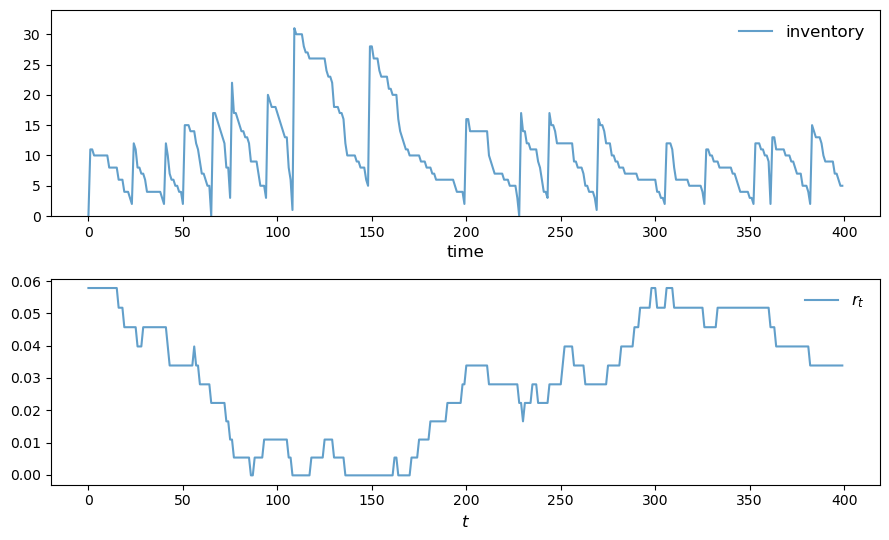

In [27]:
plot_ts(model, σ_star, figname="numba_ts.pdf", savefig=False)

## Test timing

Solving model using HPI.


HPI converged in 8 iteration(s).
TOC: Elapsed: 0:00:0.90
Solved model using HPI in 0.90696 seconds.
TOC: Elapsed: 0:00:0.90
Solving model using VFI.


TOC: Elapsed: 0:00:42.14
Solved model using VFI in 42.14682 seconds.
TOC: Elapsed: 0:00:42.14
Solving model using OPI.


OPI terminated successfully in 605 iterations (m = 1).
TOC: Elapsed: 0:00:42.47
Solved model using OPI in 42.47102 seconds.
TOC: Elapsed: 0:00:42.47
Solving model using OPI.


OPI terminated successfully in 38 iterations (m = 21).
TOC: Elapsed: 0:00:3.73
Solved model using OPI in 3.73570 seconds.
TOC: Elapsed: 0:00:3.73
Solving model using OPI.


OPI terminated successfully in 22 iterations (m = 41).
TOC: Elapsed: 0:00:2.76
Solved model using OPI in 2.76162 seconds.
TOC: Elapsed: 0:00:2.76
Solving model using OPI.


OPI terminated successfully in 19 iterations (m = 61).
TOC: Elapsed: 0:00:2.89
Solved model using OPI in 2.89371 seconds.
TOC: Elapsed: 0:00:2.89
Solving model using OPI.


OPI terminated successfully in 15 iterations (m = 81).
TOC: Elapsed: 0:00:2.72
Solved model using OPI in 2.72053 seconds.
TOC: Elapsed: 0:00:2.72


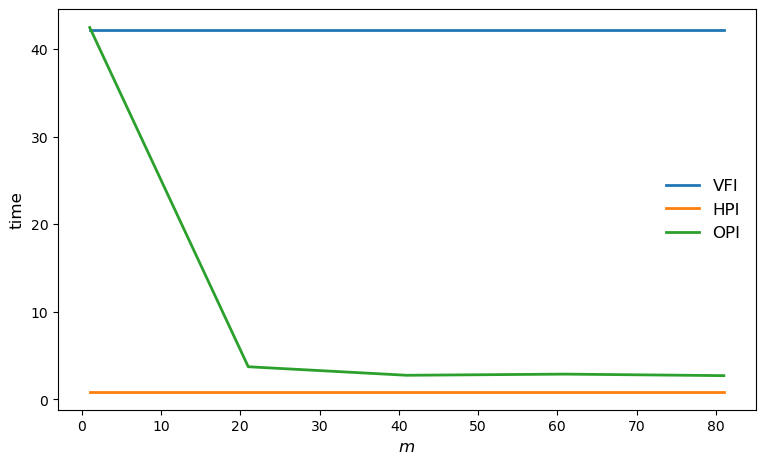

In [28]:
hpi_time, vfi_time, opi_times = test_timing_numba(model)

In [29]:
print("\nRun times relative to HPI:\n")
print(f"HPI = {hpi_time}")
print(f"VFI / HPI = {vfi_time / hpi_time}")
print(f"best OPI / HPI = {min(opi_times) / hpi_time}")


Run times relative to HPI:

HPI = 0.9069786071777344
VFI / HPI = 46.46952060700121
best OPI / HPI = 2.9995828233631534
